<a href="https://colab.research.google.com/github/johnmot/DataAnalysisProjects/blob/main/brainwave%26emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving emotions.csv to emotions.csv


In [4]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['emotions.csv']))

In [7]:
df.describe()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_710_b,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.00000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,15.256914,27.012462,-104.975629,13.605898,24.150483,0.025378,0.052282,0.301655,0.036793,0.083567,14.434887,26.908907,-105.588740,12.887584,23.926767,16.033058,27.060702,-104.679376,14.267053,24.283368,14.467447,26.959896,-105.381444,12.933635,24.003451,16.049431,27.114985,-104.290668,14.294105,24.373668,-1.599357,-0.152583,-0.91247,-1.378962,-0.356195,-0.032664,-0.051330,-0.200058,-0.047101,-0.078052,...,-17.779184,100.599180,-50.470534,-50.470534,100.599180,-14.045472,98.857898,-49.384255,-49.384255,98.857898,-40.212686,115.890981,-60.818355,-60.818355,115.890981,-20.803073,104.579728,-52.482214,-52.482214,104.579728,-10.266162,98.024481,-49.860683,-49.860683,98.024481,-39.805323,115.850926,-61.034371,-61.034371,115.850926,-22.938971,104.946111,-51.973647,-51.973647,104.946111,-6.934144,95.104886,-49.061255,-49.061255,95.104886
std,15.284621,9.265141,206.271960,16.874676,14.187340,17.981796,8.509174,68.098894,17.010031,18.935378,19.515474,11.879437,211.103804,22.367222,22.135017,24.429661,13.780414,211.082473,23.307269,16.597016,19.511804,11.860676,211.000691,22.357290,21.953792,24.443949,13.737191,210.671349,23.324362,16.212550,26.531211,15.661044,56.10358,25.660613,18.423602,23.823391,11.527922,81.363041,22.721501,29.003355,...,297.738725,208.675512,111.953662,111.953662,208.675512,286.038456,205.488648,107.187240,107.187240,205.488648,288.197813,202.162746,108.728352,108.728352,202.162746,300.098178,212.554149,113.610157,113.610157,212.554149,285.143736,205.199001,105.688402,105.688402,205.199001,287.708665,202.269233,109.084649,109.084649,202.269233,298.034311,212.532721,112.160233,112.160233,212.532721,281.040552,203.194976,106.486317,106.486317,203.194976
min,-61.300000,-114.000000,-970.000000,-137.000000,-217.000000,-218.000000,-255.000000,-1360.000000,-203.000000,-553.000000,-190.000000,-310.000000,-970.000000,-253.000000,-750.000000,-125.000000,-368.000000,-970.000000,-131.000000,-140.000000,-191.000000,-312.000000,-970.000000,-254.000000,-754.000000,-125.000000,-368.000000,-973.000000,-131.000000,-137.000000,-465.000000,-646.000000,-1130.00000,-540.000000,-614.000000,-319.000000,-428.000000,-1140.000000,-196.000000,

In [26]:
from sklearn.preprocessing import LabelEncoder


In [31]:
encoder = LabelEncoder()
encoder.fit(df['class'])
labels = encoder.transform(df['class'])
df['class'] = labels
df.head(3)

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label,class
0,4.62,30.3,-356.0,15.6,26.3,1.07,0.411,-15.70,2.06,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.7,27.9,3.17,32.2,-368.0,15.9,36.4,7.08,28.8,-359.0,17.3,19.6,-3.8300,-1.23,-10.80,-0.363,-6.41,-1.03,-2.780,14.60,-1.54,-14.90,...,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.0,-245.0,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.0,-185.0,-185.0,374.0,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.0,-162.0,280.00,NEGATIVE,0
1,28.80,33.1,32.0,25.8,22.8,6.55,1.680,2.88,3.83,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.2,32.9,31.80,33.1,33.2,28.5,26.8,32.40,34.7,33.8,27.0,14.2,0.0342,1.10,-1.87,-4.690,-15.40,-6.22,-0.328,-3.53,-6.98,-9.37,...,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.9,17.9,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.0,40.7,40.7,-19.0,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.6,-31.6,2.57,NEUTRAL,1
2,8.90,29.4,-416.0,16.7,23.7,79.90,3.360,90.20,89.90,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.4,20.0,79.80,31.0,-408.0,91.9,29.5,18.80,31.1,-335.0,32.2,19.9,76.6000,4.85,39.90,75.300,5.27,-72.00,-0.843,-33.00,-82.00,-4.20,...,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.0,-72.0,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.0,-48.8,-48.8,159.0,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.0,-148.0,281.00,POSITIVE,2


In [48]:
#데이터 종속, 독립 변수 나누기
x_data = df.drop(['class','label'], axis=1)
y_data = df['class']


In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(x_data)
principalDf = pd.DataFrame(data=printcipalComponents)
# 주성분으로 이루어진 데이터 프레임 구성
#principalDf.head()
x_data = principalDf

In [51]:


#데이터 밸런스 확인
print(y_data.value_counts())

#실험을 위한 데이터 분할하기
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.18, random_state=777, stratify=y_data)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.22, random_state=777, stratify=y_train)

import numpy as np
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_val))
print(np.shape(y_val))
print(np.shape(x_test))
print(np.shape(y_test))


1    716
2    708
0    708
Name: class, dtype: int64
(1363, 20)
(1363,)
(385, 20)
(385,)
(384, 20)
(384,)


In [56]:
# 모델링 시작
## 모니터링 매트릭스 만들기
from sklearn.metrics import roc_curve, plot_roc_curve, precision_recall_curve, confusion_matrix
import tensorflow as tf
from keras import models, layers, optimizers, initializers, metrics, losses #, regularizers
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc', curve='PR'), # Precision-Recall-curve 
          ]

In [70]:
#모델링 (단순 신경망)

#모델 구성, 컴파일 (신경망)
model_1 = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')])
model_1.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=METRICS)

EPOCHE = 20

BATCH_SIZE = 256

# 조기종료 모델
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
    )

#모델 개괄
model_1.summary()

#훈련데이터로 실험시작
normal_training = model_1.fit(x_train, y_train, 
                              batch_size=BATCH_SIZE, 
                              epochs=EPOCHE,
                              callbacks=early_stopping,
                              validation_data=(x_val, y_val),
                              verbose=1)


#모델 저장 
model_1.save("Model_1_brain")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6/6 [==============================] - 2s 116ms/step - loss: 1546009736155721.2500 - accuracy: 0.3499 - precision: 0.6869 - recall: 0.3315 - auc: 0.6771 - val_loss: 1320004108681216.0000 - val_accuracy: 0.3273 - val_precision: 0.5000 - val_recall: 0.0078 - val_auc: 0.6599
Epoch 2/20
6/6 [==============================] - 0s 11ms/step - loss: 1432971949113344.0000 - accurac

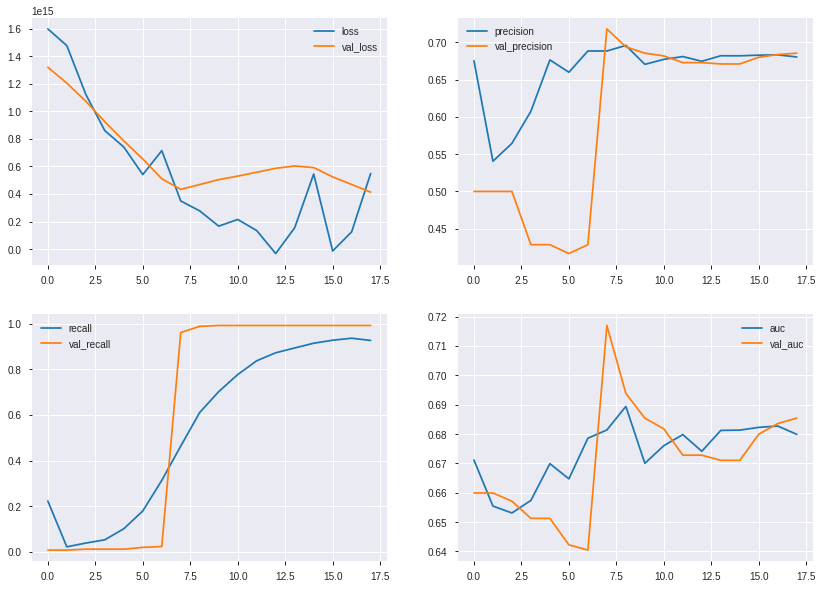

In [71]:
import matplotlib.pyplot as plt
#!pip install pandas-bokeh # plotting tool for Pandas
import pandas_bokeh
temp = pd.DataFrame(normal_training.history)
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
temp[['loss', 'val_loss']].plot.line(ax=axes[0,0])
temp[['precision', 'val_precision']].plot.line(ax=axes[0,1])
temp[['recall', 'val_recall']].plot.line(ax=axes[1,0])
temp[['auc', 'val_auc']].plot.line(ax=axes[1,1])
plt.show()

In [72]:
result = model_1.evaluate(x_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 65158382616576.0000 - accuracy: 0.4062 - precision: 0.7126 - recall: 0.9650 - auc: 0.7119
